## EDA для предсказания результатов экзамена по математике учеников школ

#### Импортируем нужные библиотеки и загружаем данные для анализа

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

students = pd.read_csv('stud_math.csv')

#### Раздел предобработки. Тут лежат функции, используемые в ходе работы с данными и их анализа.

In [2]:
def movecol(df, cols_to_move=[], ref_col='', place='After'):
    """Функция перемещения колонок внутри DataFrame"""
    cols = df.columns.tolist()
    if place == 'After':
        seg1 = cols[:list(cols).index(ref_col) + 1]
        seg2 = cols_to_move

    if place == 'Before':
        seg1 = cols[:list(cols).index(ref_col)]
        seg2 = cols_to_move + [ref_col]

    seg1 = [i for i in seg1 if i not in seg2]
    seg3 = [i for i in cols if i not in seg1 + seg2]

    return(df[seg1 + seg2 + seg3])


def get_stat_dif(data, column, column_score, quantity=5):
    """Функция для оценки статистически значимих различий номинативных признаков"""
    data_vc = data.loc[data[column].notnull(), column].value_counts()
    print("Значений, встретившихся в столбце более",
          quantity, "раз:", len(data_vc[data_vc > quantity]))

    # Если значение признака в столбце встречается менее 5 раз,
    # то оценивать его значимость статистически не имеет смысла

    cols = data_vc[data_vc > quantity].index[:]
    combinations_all = list(combinations(cols, 2))

    founded = 0  # для интереса посчитаем сколько комбинаций признаков будут статистически значимы
    for comb in combinations_all:
        ttest = ttest_ind(data.loc[data.loc[:, column] == comb[0], column_score],
                          data.loc[data.loc[:, column] == comb[1], column_score]).pvalue
        #print(comb, ttest)
        if ttest <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            founded += 1
    if founded > 0:
        print('Найдены статистически значимые различия для колонки', column,
              'в количестве', founded, 'комбинаций из', len(combinations_all))
    else:
        print('НЕ Найдены статистически значимые различия для колонки', column)


def get_boxplot(dataset, column, column_score):
    """Функция выводит box-plot"""
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y=column_score,
                data=dataset, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def nominative_analysis(dataset, column, column_score):
    """Выводит Box-Plot и оценивает статистическую значимость"""
    get_boxplot(dataset, column, column_score)
    get_stat_dif(dataset, column, column_score)


def correlation(dataset, x_col, y_col):
    """Оцениваем корреляцию между двумя признаками"""
    sns.jointplot(x=x_col, y=y_col,
                  data=dataset, kind='reg')
    display(('Jointplot for ' + x_col), dataset[[x_col, y_col]].corr())
    plt.show()

#### Первичный осмотр данных.

In [3]:
# display(students.sample(10))
students.info()

# DataFrame с количеством пустых значений по колонкам
nulldata = pd.DataFrame(students.isnull().sum())
nulldata.columns = ['null_num']
nulldata['null_proc'] = round(
    100 * nulldata['null_num'] / len(students), 0)  # % незаполненных данных
display(nulldata)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

,null_num,null_proc
school,0,0.0
sex,0,0.0
age,0,0.0
address,17,4.0
famsize,27,7.0
Pstatus,45,11.0
Medu,3,1.0
Fedu,24,6.0
Mjob,19,5.0
Fjob,36,9.0


Исходный Датасет состоит из 30 колонок и содержит данные о 395 учениках. 13 из них числовые, остальные - строковые. По факту согласно условию задачи числовыми можно считать столбцы score, absences, failures и, возможно, age. Анализ данных на пропуски показал, что только в столбцах school, sex и age отсутствуют пустые значения. Максимальное количество пропусков в столбце Pstatus, однако оно составляет всего 11%. Оценим пропуски на графике.

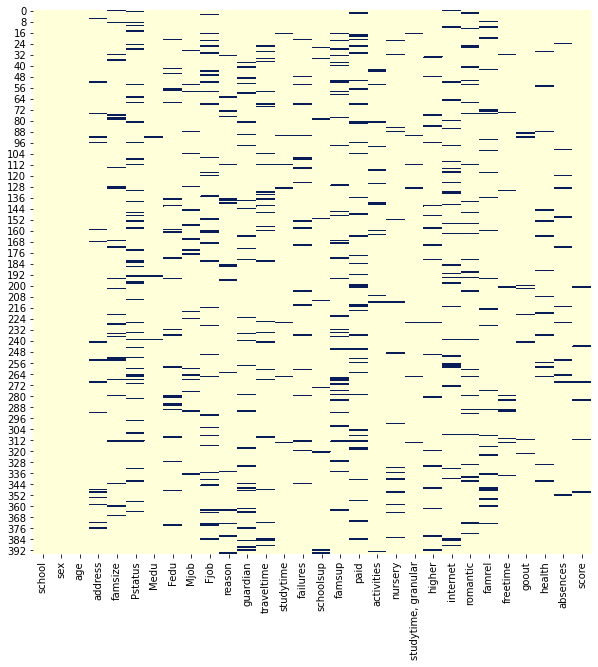

In [4]:
plt.figure(figsize=(10, 10))
sns.heatmap(students.isnull(), cbar=False, cmap='YlGnBu')
plt.ioff()

Имеются пропуски в целевом столбце score. Т.к. оценить влияние признаков на отсутствующее значение целевой величины не представляется возможным, а также на текущем этапе нет возможности сделать прогноз значения score, то указанные строки из рассмотрения нужно удалить. В дальнейшем после построения модели можно было бы оценить значение предсказываемой величины в ходе тестирования.

In [5]:
# удаляем строки с пустым score
students.dropna(subset=['score'], inplace=True)

#### Рассмотрим целевой столбец score.

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

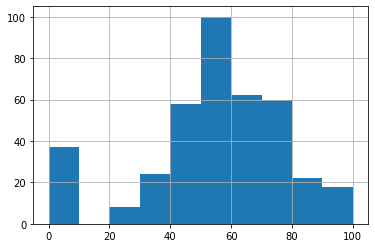

In [6]:
students.score.hist()
students.score.describe()

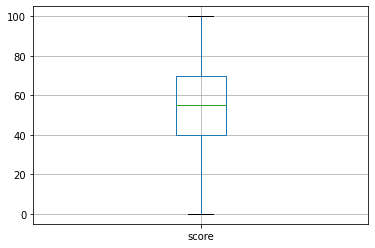

In [7]:
boxplot = students.boxplot(column=['score'])

Целевая величина распределена относительно нормально. Медианное значение - 55, нижний квартиль - 40, верхний - 75. Есть значительный скачок величины в 0, стоит более пристально рассмотреть этот момент.
#### Поиск выбросов номинативных переменных

In [8]:
pd.set_option('display.html.table_schema', True)
for col in students.columns[:-2]:
    display(col, students[col].value_counts())

'school'

GP    344
MS     45
Name: school, dtype: int64

'sex'

F    204
M    185
Name: sex, dtype: int64

'age'

16    103
17     98
15     82
18     80
19     21
20      3
22      1
21      1
Name: age, dtype: int64

'address'

U    291
R     83
Name: address, dtype: int64

'famsize'

GT3    255
LE3    107
Name: famsize, dtype: int64

'Pstatus'

T    308
A     36
Name: Pstatus, dtype: int64

'Medu'

4.0    131
2.0    100
3.0     96
1.0     56
0.0      3
Name: Medu, dtype: int64

'Fedu'

2.0     105
3.0      94
4.0      88
1.0      75
0.0       2
40.0      1
Name: Fedu, dtype: int64

'Mjob'

other       127
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64

'Fjob'

other       194
services     99
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64

'reason'

course        135
reputation    102
home          101
other          34
Name: reason, dtype: int64

'guardian'

mother    248
father     86
other      24
Name: guardian, dtype: int64

'traveltime'

1.0    239
2.0     94
3.0     21
4.0      7
Name: traveltime, dtype: int64

'studytime'

2.0    189
1.0    103
3.0     63
4.0     27
Name: studytime, dtype: int64

'failures'

0.0    290
1.0     48
2.0     15
3.0     14
Name: failures, dtype: int64

'schoolsup'

no     331
yes     49
Name: schoolsup, dtype: int64

'famsup'

yes    216
no     135
Name: famsup, dtype: int64

'paid'

no     197
yes    153
Name: paid, dtype: int64

'activities'

yes    192
no     183
Name: activities, dtype: int64

'nursery'

yes    297
no      77
Name: nursery, dtype: int64

'studytime, granular'

-6.0     189
-3.0     103
-9.0      63
-12.0     27
Name: studytime, granular, dtype: int64

'higher'

yes    350
no      19
Name: higher, dtype: int64

'internet'

yes    300
no      55
Name: internet, dtype: int64

'romantic'

no     235
yes    123
Name: romantic, dtype: int64

'famrel'

 4.0    178
 5.0     97
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

'freetime'

3.0    152
4.0    110
2.0     63
5.0     37
1.0     18
Name: freetime, dtype: int64

'goout'

3.0    126
2.0    101
4.0     81
5.0     51
1.0     23
Name: goout, dtype: int64

'health'

5.0    137
3.0     88
4.0     60
1.0     47
2.0     42
Name: health, dtype: int64

В столбцах Fedu и famrel присутствуют значения, не соответствующие изначальному описанию данных. Очистим эти величины.

In [9]:
# В столбце Fedu есть как минимум 1 выброс из имеющейся шкалы, делаем его NaN
students.loc[students['Fedu'] > 4, 'Fedu'] = np.nan
# В столбце famrel есть как минимум 1 выброс из имеющейся шкалы, делаем его NaN
students.loc[students['famrel'] < 1, 'famrel'] = np.nan

Также был обнаружен столбец "studytime, granular", который по количеству значений совпадает со столбцом "studytime". Проверим как они коррелируют друг с другом.

In [10]:
students[['studytime', 'studytime, granular']].corr()

,studytime,"studytime, granular"
studytime,1.0,-1.0
"studytime, granular",-1.0,1.0


Столбцы полностью повторяют друг друга, поэтому "studytime, granular" можно удалить.

In [11]:
# Удаляем лишний столбец.
students.drop('studytime, granular', axis=1, inplace=True)

#### Рассмотрим столбец absences

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

(-0.386, 38.5]    372
(38.5, 77.0]        4
(346.5, 385.0]      1
(192.5, 231.0]      1
(308.0, 346.5]      0
(269.5, 308.0]      0
(231.0, 269.5]      0
(154.0, 192.5]      0
(115.5, 154.0]      0
(77.0, 115.5]       0
Name: absences, dtype: int64

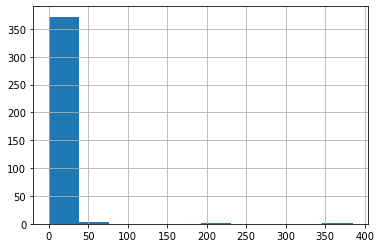

In [12]:
students.absences.hist(bins=10)
display(students.absences.describe(), students.absences.value_counts(bins=10))

Основная часть данных находится в диапазоне от 0 до 38. Нижний квартиль совпадает с минимальным значением и находится в 0, медиана - на отметке 4, верхний квартиль - 8. Наблюдаются единичные выбросы (>50) которые являются малореалистичными или крайне нереалистичными. Рассмотрим данные более подробно.

In [13]:
display(students[students.absences.between(
    0, 40)].absences.value_counts(bins=10))
perc25 = students.absences.quantile(0.25)
perc75 = students.absences.quantile(0.75)
IQR = perc75 - perc25
print(perc25 - 1.5*IQR, perc75 + 1.5*IQR)
display(students[~students.absences.between(perc25 - 1.5*IQR,
                                            perc75 + 1.5*IQR)].absences.value_counts(bins=10))

(-0.041, 4.0]    232
(4.0, 8.0]        61
(8.0, 12.0]       34
(12.0, 16.0]      23
(16.0, 20.0]      11
(20.0, 24.0]       6
(24.0, 28.0]       3
(36.0, 40.0]       2
(28.0, 32.0]       1
(32.0, 36.0]       0
Name: absences, dtype: int64

-12.0 20.0


(20.634999999999998, 57.4]    14
(348.6, 385.0]                 1
(203.0, 239.4]                 1
(57.4, 93.8]                   1
(312.2, 348.6]                 0
(275.8, 312.2]                 0
(239.4, 275.8]                 0
(166.6, 203.0]                 0
(130.2, 166.6]                 0
(93.8, 130.2]                  0
Name: absences, dtype: int64

На основании метода IQR выбросами можно считать все значения, которые превышают 20. Однако есть около 10 значений в диапазоне от 20 до 30, что составляет около 3% нашего объема данных и в принципе не является чем-то ненормальным, ученик вполне может 1-1,5 месяца быть на больничном в течение года, а учитывая, что распредение признака трудно назвать полностью нормальным, будем считать выбросами значения признака, которые превышают 30. Очистим столбец от выбросов.

In [14]:
students.loc[students['absences'] > 30, 'absences'] = np.nan

Теперь столбец absences выглядит так:

count    371.000000
mean       5.140162
std        5.884637
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       30.000000
Name: absences, dtype: float64

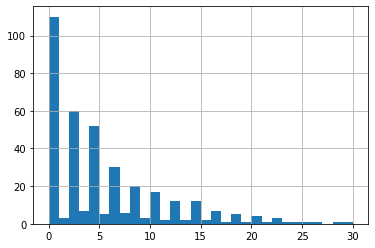

In [15]:
students.absences.hist(bins=30)
display(students.absences.describe())

График представляет собой гиперболу. Посмотрим, как количество пропусков коррелирует с оценкой на экзамене.

'Jointplot for absences'

,absences,score
absences,1.000000,0.068886
score,0.068886,1.000000


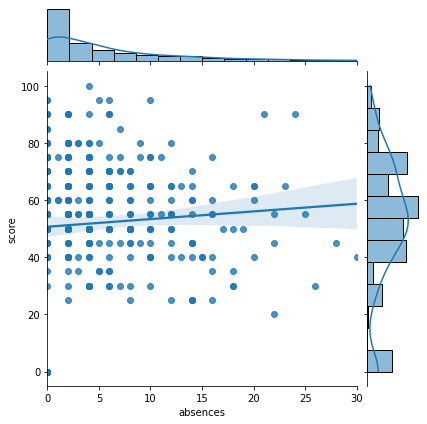

In [16]:
correlation(students, 'absences', 'score')

Значения переменных никак не коррелируют между собой. Есть очень странная тенденция, что 0 баллов на экзамене получили только те ученики, которые ни разу не пропускали занятия. 0 баллов на экзамене это не только "полное незнание предмета", возможно это значит что ученик был удален с экзамена за нарушение правил, либо не явился на экзамен по каким-то обстоятельствам, поэтому имеет смысл отдельно рассмотреть, какие признаки влияют на получение 0 на экзамене, а затем уже, какие признаки влияют на итоговую оценку на экзамене.

#### Рассмотрим столбец age

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

16    103
17     98
15     82
18     80
19     21
20      3
22      1
21      1
Name: age, dtype: int64

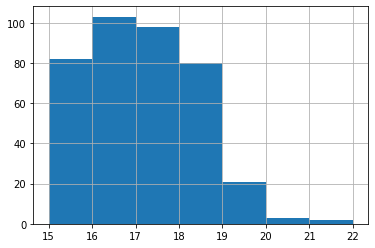

In [17]:
students.age.hist(bins=7)
display(students.age.describe(), students.age.value_counts())

Видно, что подавляющее большинство студентов в возрасте от 15 до 18. Есть небольшая группа студентов (около 5%) в возрасте 19 лет, студентов в возрасте старше 19 всего 4 человека, т.е. около 1%. Вехний квартиль - 18, нижний квартиль - 16, таким образом межквартильный интервал(IQR) - 2. Верхний квартиль + 1,5\*IQR = 21. Если рассматривать age как количественную переменную, то возраст 22 уже можно считать выбросом. Посмотрим, как возраст коррелирует с итоговой отметкой.

'Jointplot for age'

,age,score
age,1.000000,-0.155726
score,-0.155726,1.000000


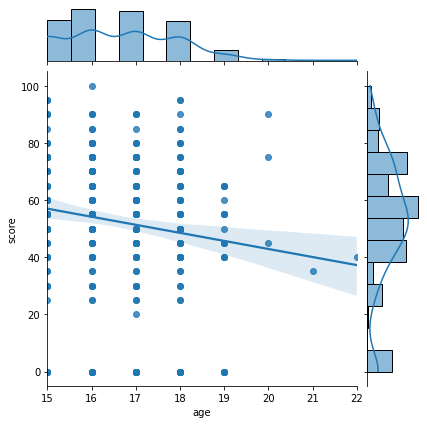

In [18]:
correlation(students, 'age', 'score')

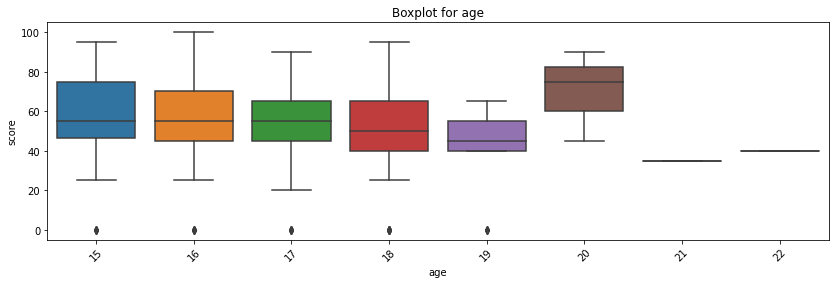

In [19]:
get_boxplot(students, 'age', 'score')

Значения переменных age и score очень слабо коррелируют между собой. Студенты получившие 0 на экзамене есть во всех основных возростных группах, цвет маркеров на графике совпадает, что говорит о том, что количество таких студентов в каждой группе приблизительно совпадает. На графике Box-Plot видно, что score=0 является выбросом во всех возрастных группах. Посмотрим на график Box-Plot на датасете без этих значений целевой переменной.

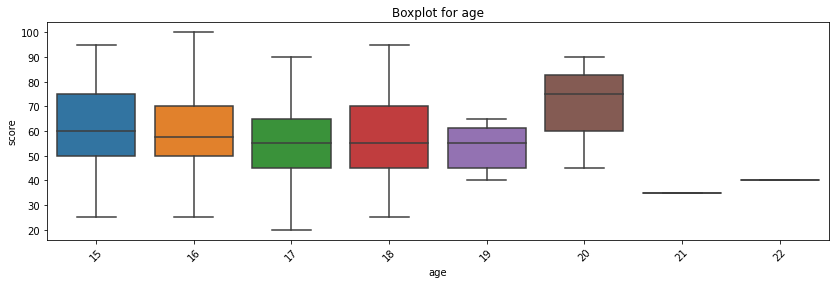

In [20]:
get_boxplot(students.query('score != 0'), 'age', 'score')

Рассмотрим корреляцию в отсутствии нулевых значений score:

'Jointplot for age'

,age,score
age,1.000000,-0.131542
score,-0.131542,1.000000


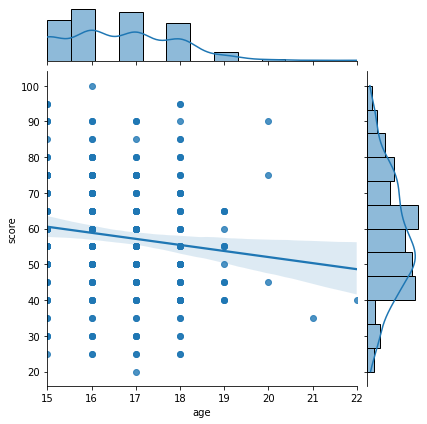

In [21]:
correlation(students.query('score != 0'), 'age', 'score')

Значение коэффициента корреляции уменьшилось, что говорит о довольно слабой зависимости показателей как количественных переменных. Еще раз рассмотрим age как номинативную переменную. По возростам 21 и 22 года есть только по одному значению целевой переменной, что недостаточно для прогнозирования, к тому же эти значения совершенно не попадают в распределение целевой переменной для возростов 19 или 20, из-за чего объединить 19-22 в одну группу не представляется возможным. Оценим age на предмет статистически значимых различий по отношению к score.

In [22]:
print(get_stat_dif(students, 'age', 'score', 1)) #оцениваем весь массив данных
# Специально задаем показатель quantity=1, чтобы в выборку попала группа учеников в возрасте 20 лет,
# которая сильно выделяется на графике Box-Plot
print(get_stat_dif(students.query('score != 0'), 'age', 'score', 1)) #оцениваем без нулевых оценок

Значений, встретившихся в столбце более 1 раз: 6
НЕ Найдены статистически значимые различия для колонки age
None
Значений, встретившихся в столбце более 1 раз: 6
НЕ Найдены статистически значимые различия для колонки age
None


Таким образом влияние возраста студента на успешность сдачи экзамена стремится к нулю и не представляет интереса, ни как количественная, ни как номинативная переменная, соответственно из дальнейшего рассмотрения эту колонку скорее всего можно будет исключить.

Вернемся к рассмотрению столбца absences, рассмотрим как он коррелирует с целевой переменной в отсутствии нулевых значений score.

'Jointplot for absences'

,absences,score
absences,1.000000,-0.226403
score,-0.226403,1.000000


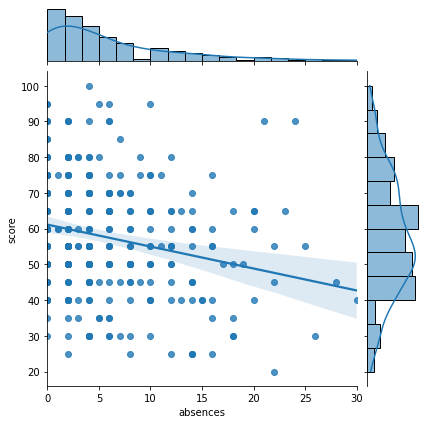

In [23]:
correlation(students.query('score != 0'), 'absences', 'score')

(-0.031, 2.0]    173
(2.0, 4.0]        59
(4.0, 6.0]        35
(6.0, 8.0]        26
(8.0, 10.0]       20
(12.0, 14.0]      14
(10.0, 12.0]      14
(14.0, 16.0]       9
(16.0, 18.0]       6
(18.0, 20.0]       5
(20.0, 22.0]       4
(24.0, 26.0]       2
(22.0, 24.0]       2
(28.0, 30.0]       1
(26.0, 28.0]       1
Name: absences, dtype: int64

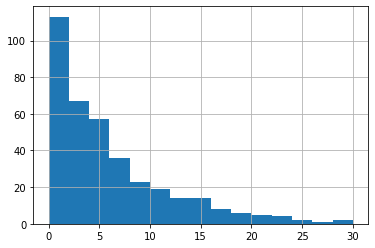

In [24]:
students.absences.hist(bins=15)
students.absences.value_counts(bins=15)

В отсутствии нулевых значений целевой переменной наблюдается слабая корреляция между показателями. Гипотеза, что чем больше ученик пропускает, тем хуже у него оценка на экзамене выглядит логичной и вполне реалистичной.
Стоит дополнительно рассмотреть переменную absences как номинативную. Для этого добавим в Датасет столбец abs_cat заполним его следующими показателями согласно количественному распределению признака на гистограмме:  
'no' - 0 пропусков  
'few' - от 1 до 4 пропусков  
'some' - от 5 до 11 пропусков  
'many' - от 12 пропусков  
Также сделаем отдельную колонку score0 для оценки влияния номинативных признаков на вероятность получения студентом 0 баллов за экзамен. Заполним значения так: 0 если у ученика "0" на экзамене или 1 если у ученика балл отличный от "0".

In [25]:
students['abs_cat'] = students[students.absences.notnull()].absences.apply(
    lambda x: 'no' if x == 0 else ('few' if 0 < x <= 4 else ('some' if 4 < x < 12 else 'many')))
# Пустые значения absences в новой колонке также остаются пустыми
students['score0'] = students.score.apply(lambda x: 0 if x == 0 else 1)

In [26]:
# Передвинем колонки, чтобы с ними было удобно работать, для этого была написана функция movecol
students = movecol(students, cols_to_move=['abs_cat', 'score0'],
                   ref_col='absences', place='Before')
students.info()  # Проверяем, что получилось

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   Pstatus     344 non-null    object 
 6   Medu        386 non-null    float64
 7   Fedu        364 non-null    float64
 8   Mjob        370 non-null    object 
 9   Fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   382 non-null    float64
 14  failures    367 non-null    float64
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

#### Рассмострим остальные колонки с числовым типом данных
Остались колонки Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, health  
Рассмотрим сначала их как количественные признаки и оценим корреляцию между собой и с целевой переменной score.  
Сначала рассмотрим failures.

'Jointplot for failures'

,failures,score
failures,1.000000,-0.344338
score,-0.344338,1.000000


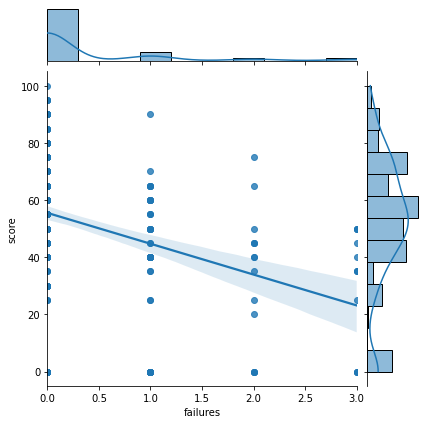

In [27]:
correlation(students, 'failures', 'score')

failures наряду с absences наверное единственные полностью количественные переменные.  
Распредение значений столбца имеет также как и absences форму гиперболы.

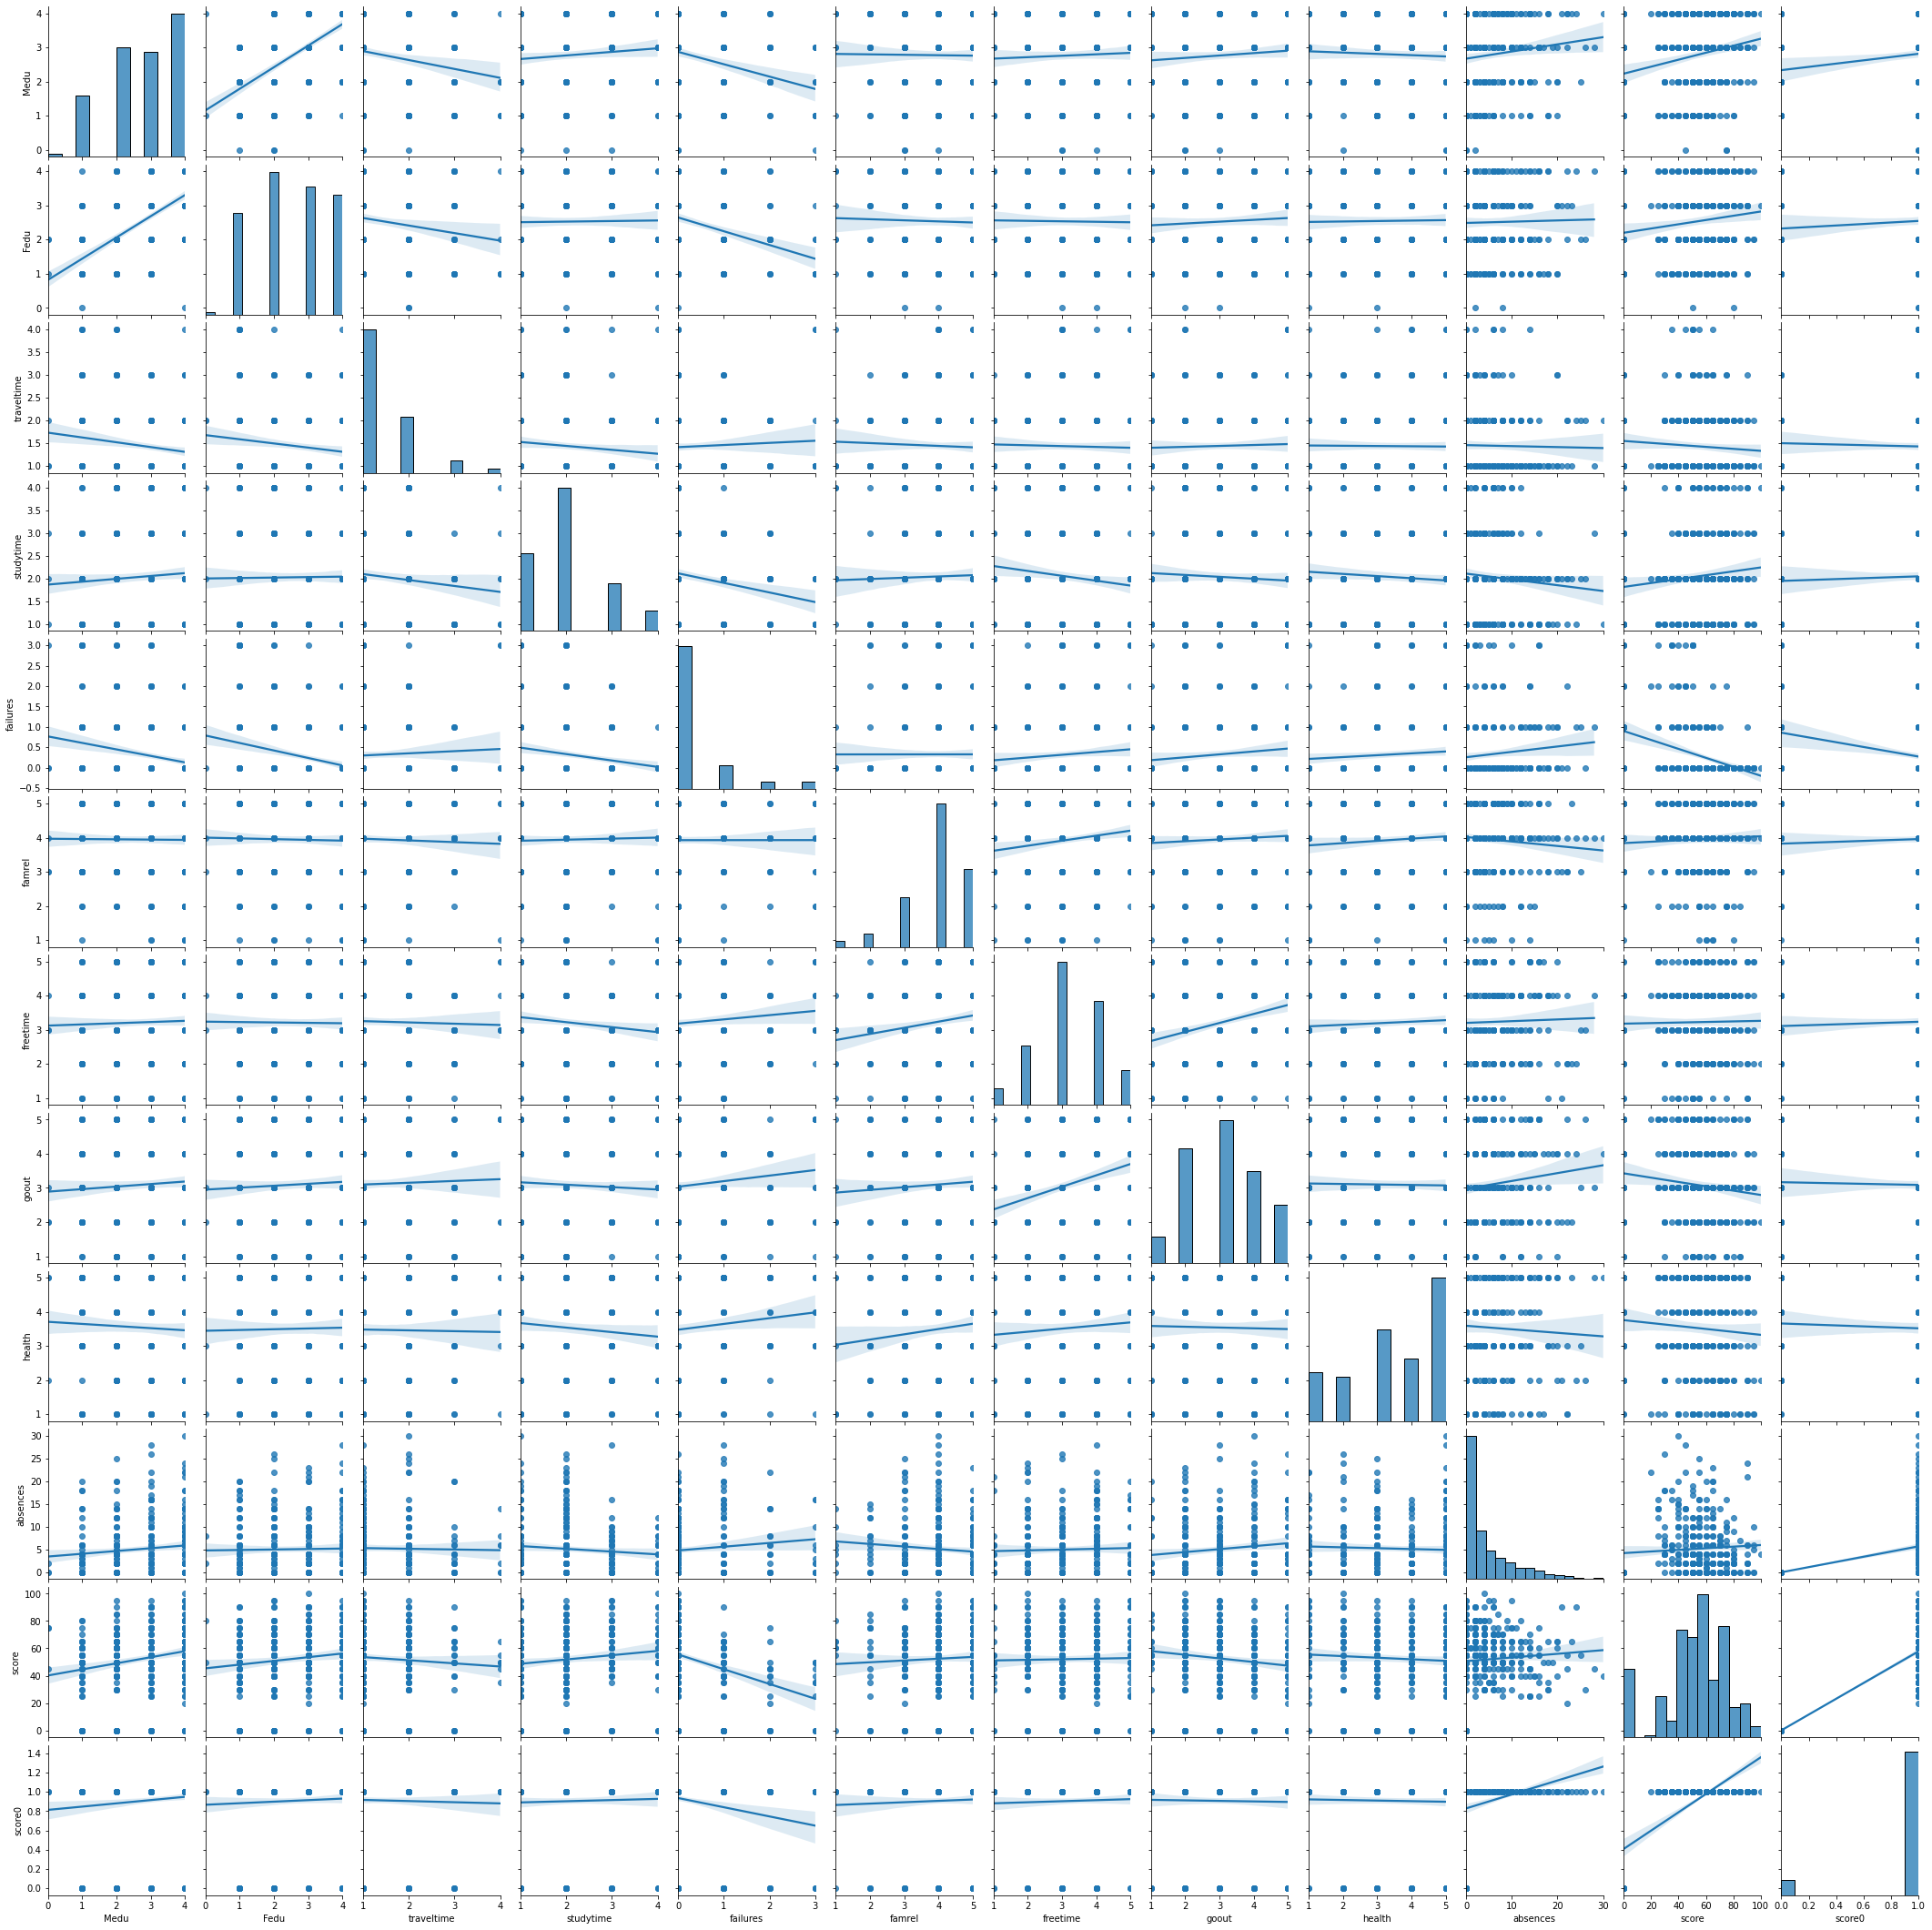

In [28]:
cols = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
        'freetime', 'goout', 'health', 'absences', 'score', 'score0']
sns.pairplot(students.loc[:, cols], kind='reg')

<AxesSubplot:>

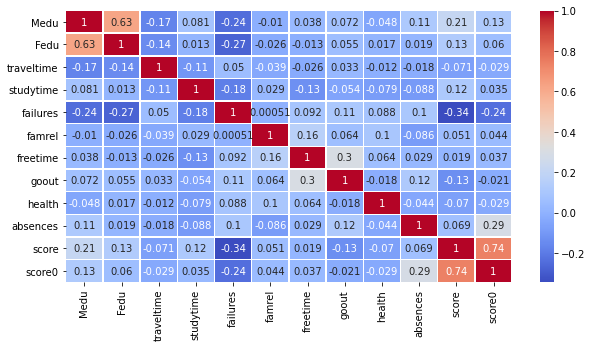

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(students.loc[:, cols].corr(), annot=True,
            linewidths=.5, cmap='coolwarm')

1) Medu и Fedu сильно коррелируют между собой, что кажется логичным. Наблюдается слабая корреляция с целевой переменной.  
2) traveltime, studytime, freetime, goout. Также наблюдаются еле различимые логичные взаимосвязи как между переменными так и во взаимосвязи с переменными failures и absences. С целевой переменной score коррелируют только studytime и goout, но слабо.  
3) failures единственная переменная, которую наряду с absences можно считать количественной. Наблюдается корреляция с целевой переменной score.  
4) Колонка score0 по сравнению с score коррелирует только с absences. Гипотеза, что студенты, которые больше пропускают чаще получают 0 на экзамене выглядит несколько абсурдной.  
Рассмотрим дополнительно как коррелируют переменные в отсутствии нулевых оценок за экзамен.

<AxesSubplot:>

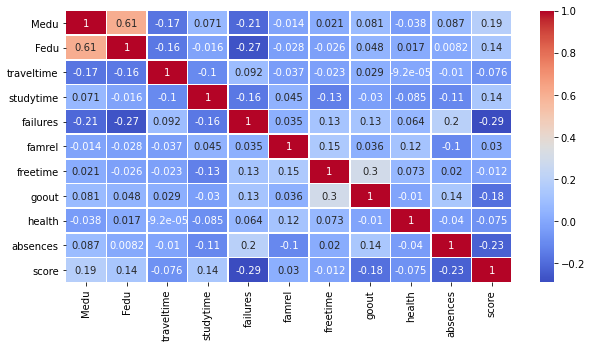

In [30]:
cols = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
        'famrel', 'freetime', 'goout', 'health', 'absences', 'score']
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(students.loc[students.score != 0, cols].corr(),
            annot=True, linewidths=.5, cmap='coolwarm')

При исключении из рассмотрения строк с оценкой 0 за экзамен, отмеченные ранее переменные продолжают коррелировать со score, причем коэффициент корреляции для каждой из них увеличивается.  
Таким образом в ходе корреляционного анализа количественных переменных были установлены зависимости целевой переменной score со следующими колонками:  
Medu, Fedu, studytime, failures, goout, absences  
В то же время почти все количественные переменные, кроме failures и absences можно также рассмотреть как номинативные, после чего сделать дополнительные выводы об их значимости.  
#### Проводим анализ номинативных переменных
Из рассмотрения убираем количественные переменные failures, absences, остальные количественные переменные можно рассматривать как номинативные, добавляем номинативную переменную по количеству пропусков abs_cat.

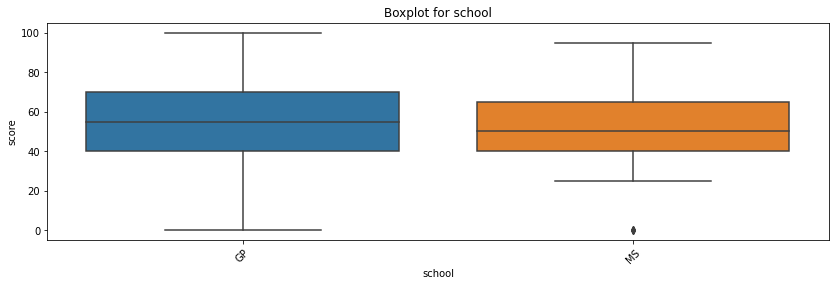

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки school


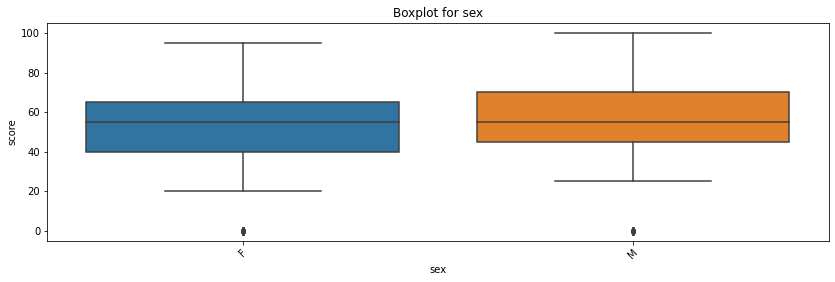

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки sex


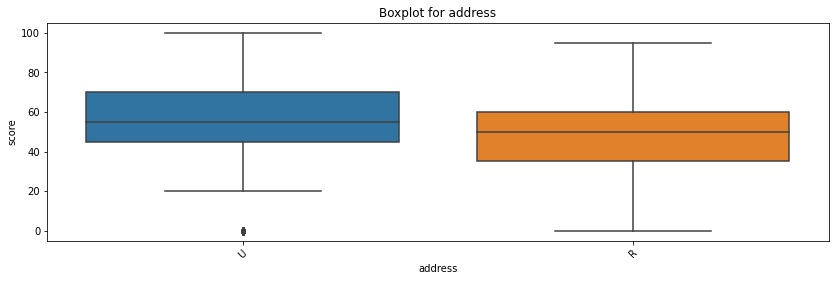

Значений, встретившихся в столбце более 5 раз: 2
Найдены статистически значимые различия для колонки address в количестве 1 комбинаций из 1


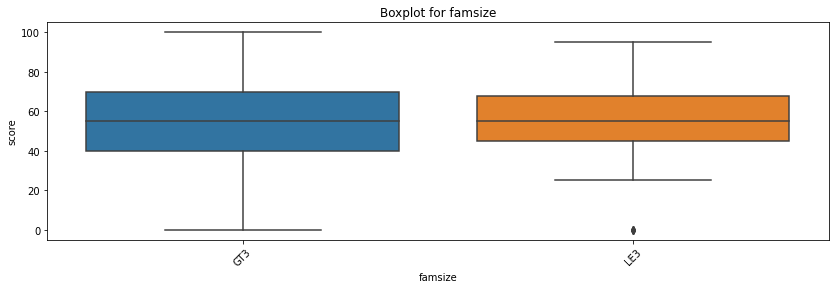

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки famsize


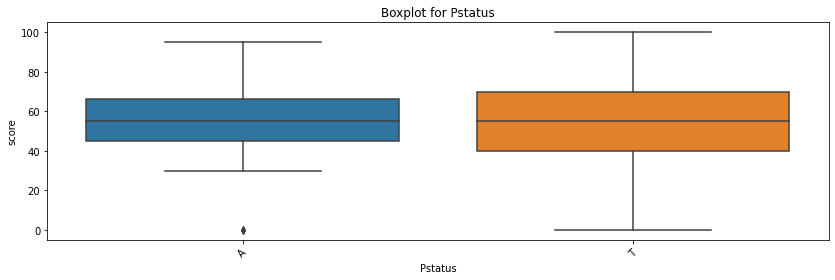

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки Pstatus


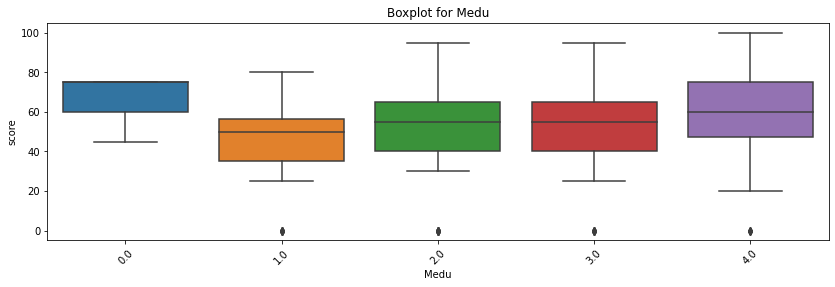

Значений, встретившихся в столбце более 5 раз: 4
Найдены статистически значимые различия для колонки Medu в количестве 2 комбинаций из 6


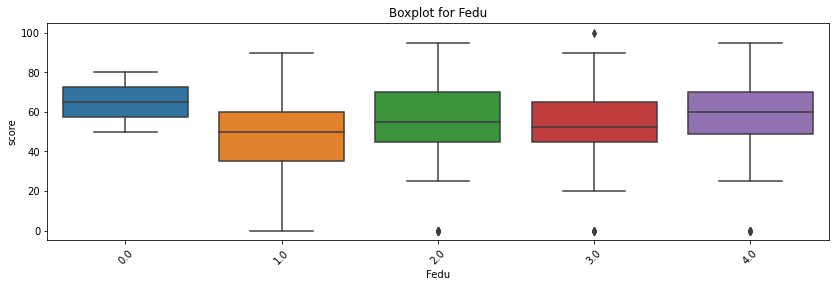

Значений, встретившихся в столбце более 5 раз: 4
НЕ Найдены статистически значимые различия для колонки Fedu


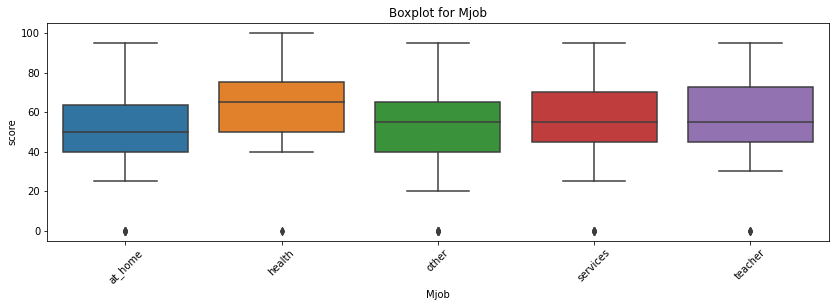

Значений, встретившихся в столбце более 5 раз: 5
Найдены статистически значимые различия для колонки Mjob в количестве 1 комбинаций из 10


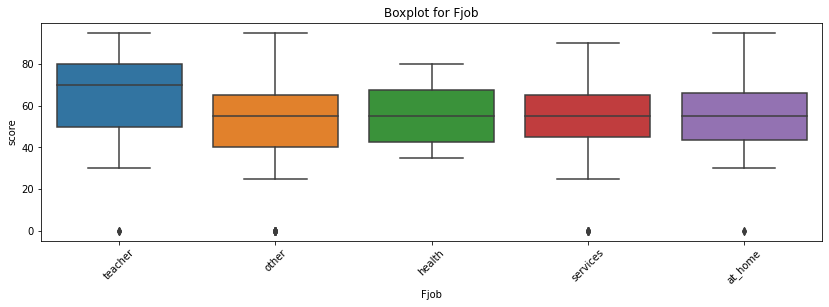

Значений, встретившихся в столбце более 5 раз: 5
НЕ Найдены статистически значимые различия для колонки Fjob


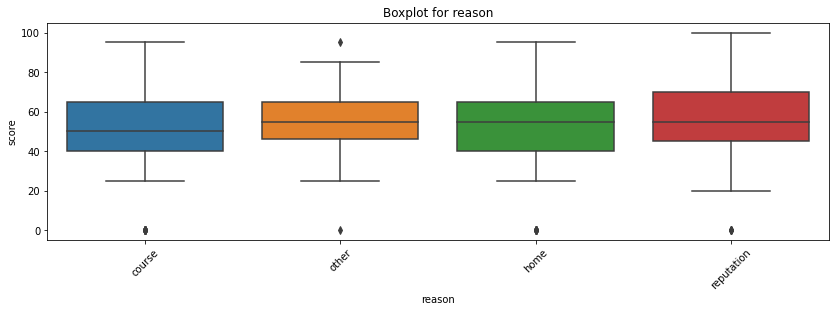

Значений, встретившихся в столбце более 5 раз: 4
НЕ Найдены статистически значимые различия для колонки reason


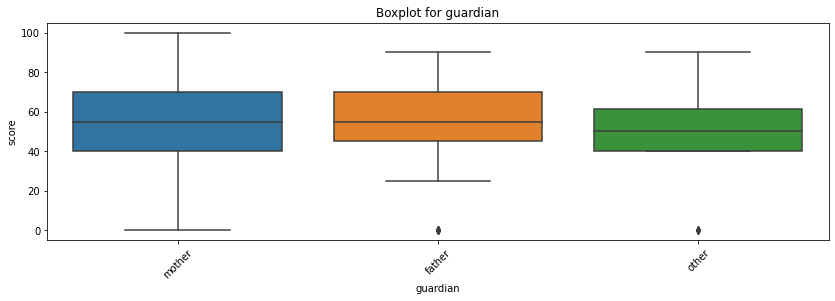

Значений, встретившихся в столбце более 5 раз: 3
НЕ Найдены статистически значимые различия для колонки guardian


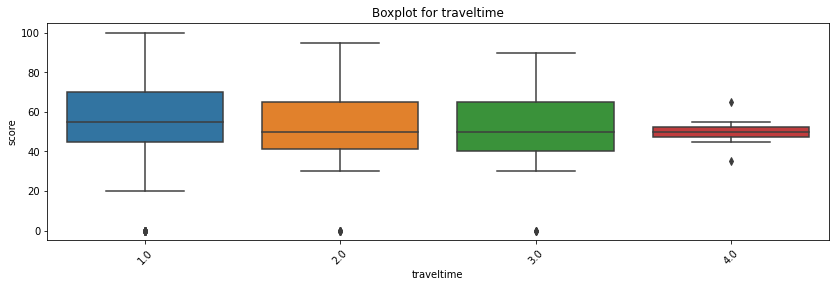

Значений, встретившихся в столбце более 5 раз: 4
НЕ Найдены статистически значимые различия для колонки traveltime


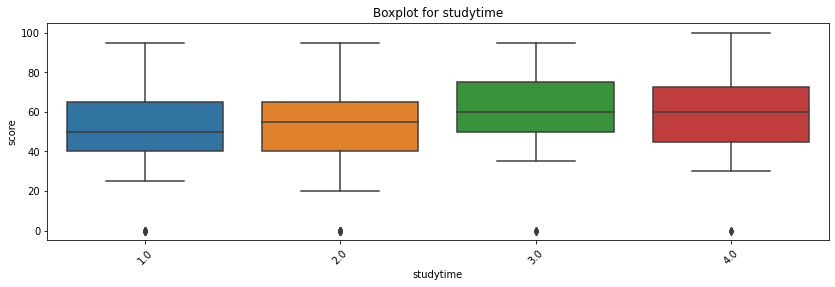

Значений, встретившихся в столбце более 5 раз: 4
НЕ Найдены статистически значимые различия для колонки studytime


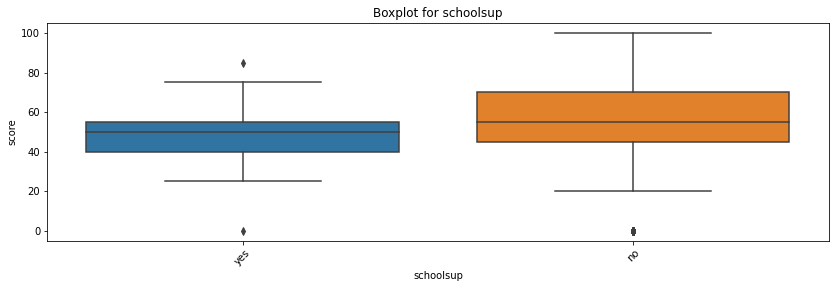

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки schoolsup


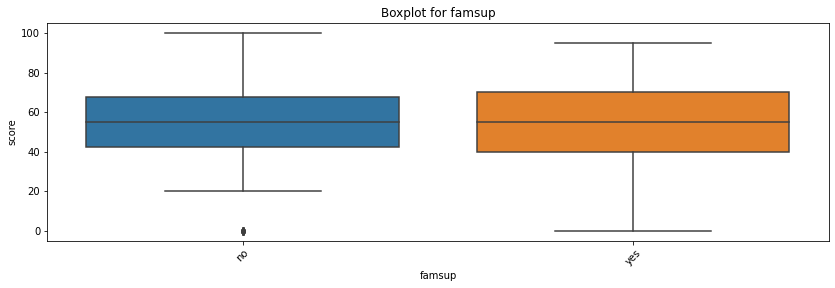

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки famsup


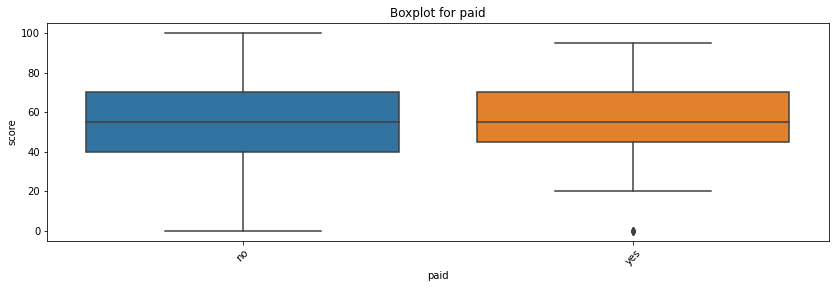

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки paid


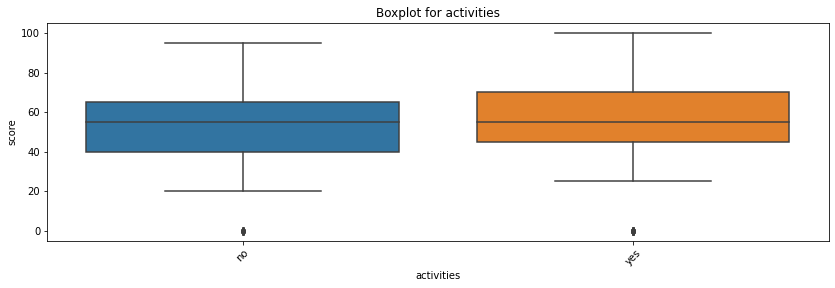

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки activities


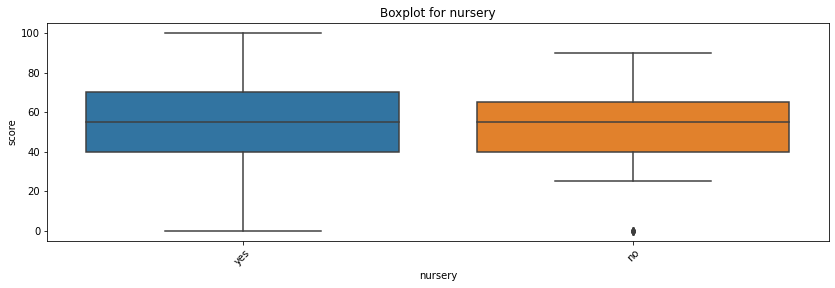

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки nursery


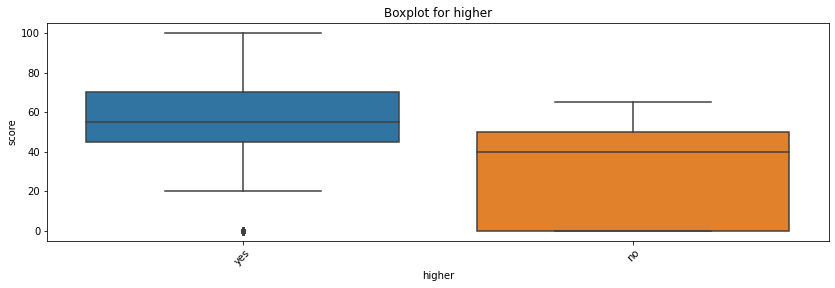

Значений, встретившихся в столбце более 5 раз: 2
Найдены статистически значимые различия для колонки higher в количестве 1 комбинаций из 1


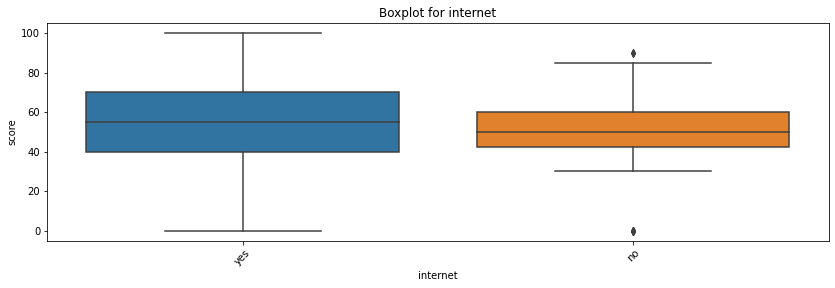

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки internet


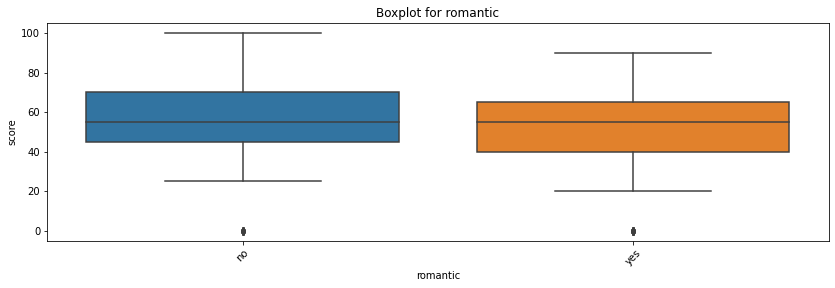

Значений, встретившихся в столбце более 5 раз: 2
Найдены статистически значимые различия для колонки romantic в количестве 1 комбинаций из 1


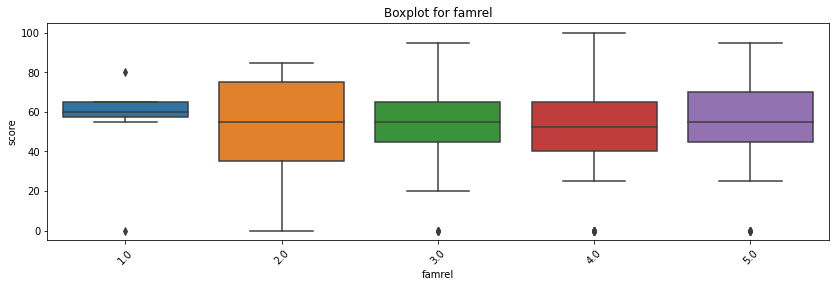

Значений, встретившихся в столбце более 5 раз: 5
НЕ Найдены статистически значимые различия для колонки famrel


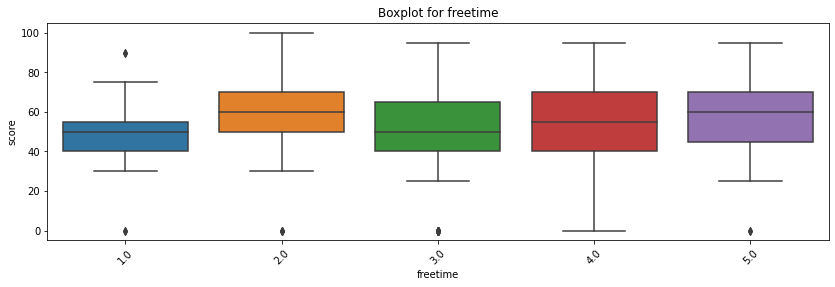

Значений, встретившихся в столбце более 5 раз: 5
НЕ Найдены статистически значимые различия для колонки freetime


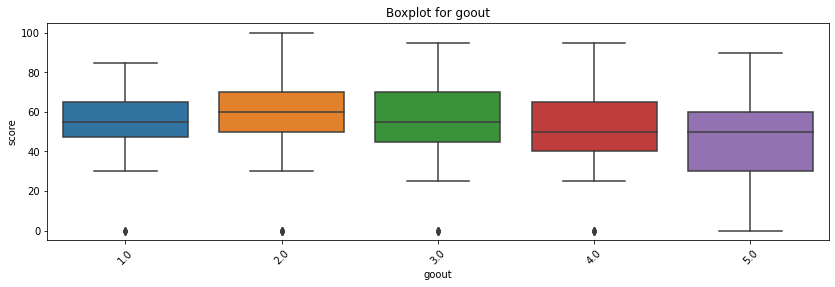

Значений, встретившихся в столбце более 5 раз: 5
Найдены статистически значимые различия для колонки goout в количестве 1 комбинаций из 10


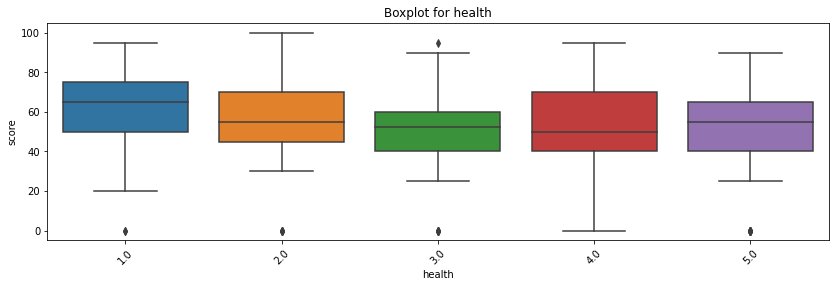

Значений, встретившихся в столбце более 5 раз: 5
НЕ Найдены статистически значимые различия для колонки health


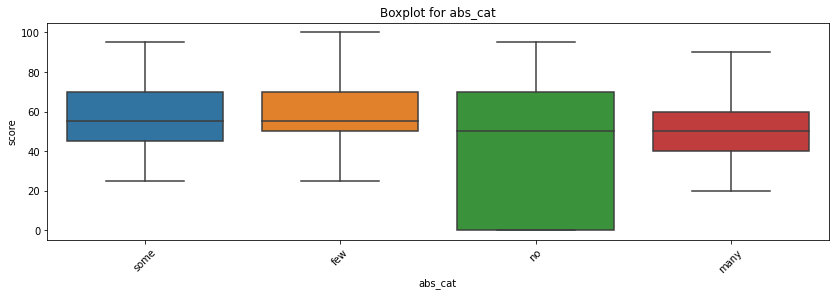

Значений, встретившихся в столбце более 5 раз: 4
Найдены статистически значимые различия для колонки abs_cat в количестве 3 комбинаций из 6


In [31]:
cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
        'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
        'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
        'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
        'health', 'abs_cat']
for col in cols:
    nominative_analysis(students, col, 'score')

Статистически значимые различия показали следующие столбцы:  
address, Medu, Mjob, higher, romantic, goout, abs_cat  
Теперь посмотрим как номинативные переменные влияют на score в отсутствии нулевых оценок за экзамен.

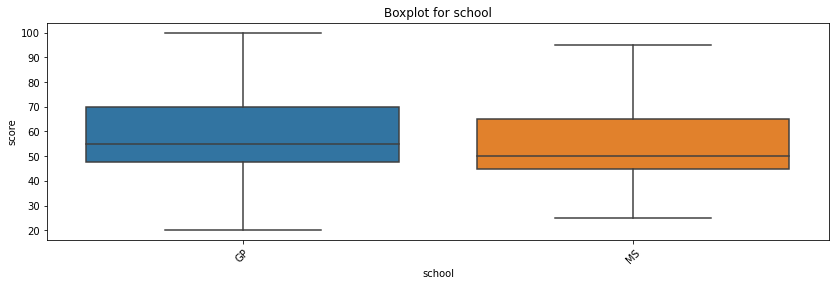

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки school


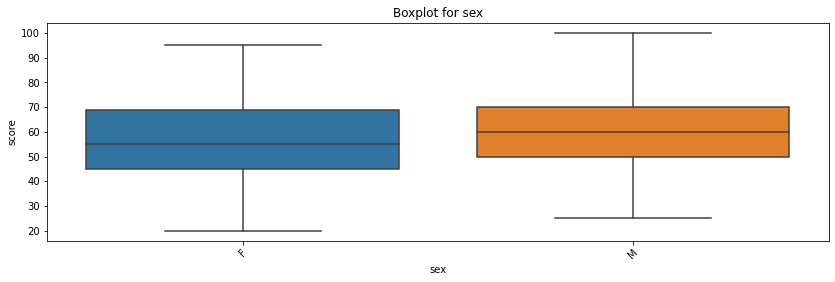

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки sex


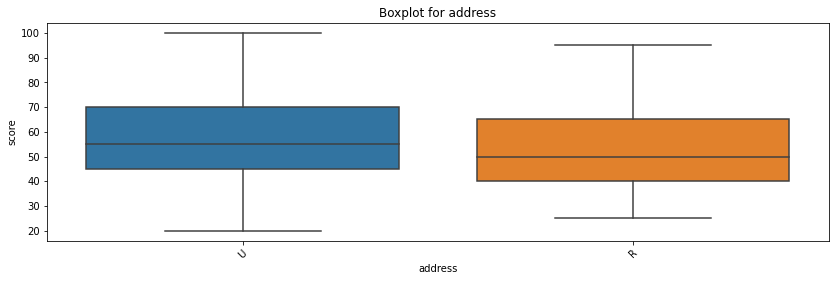

Значений, встретившихся в столбце более 5 раз: 2
Найдены статистически значимые различия для колонки address в количестве 1 комбинаций из 1


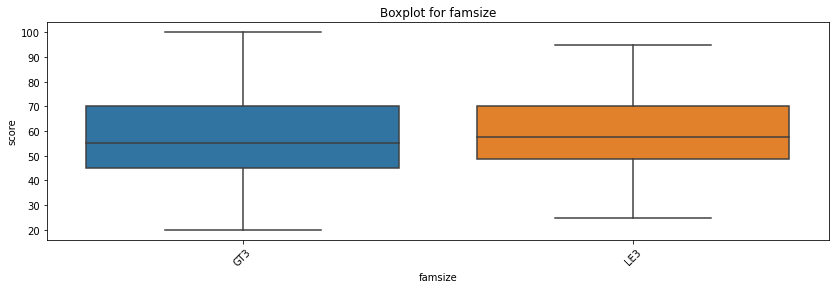

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки famsize


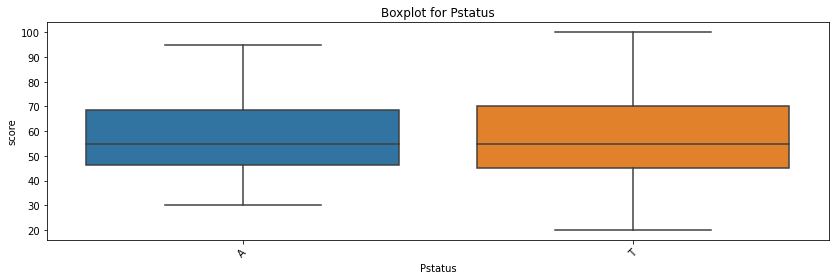

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки Pstatus


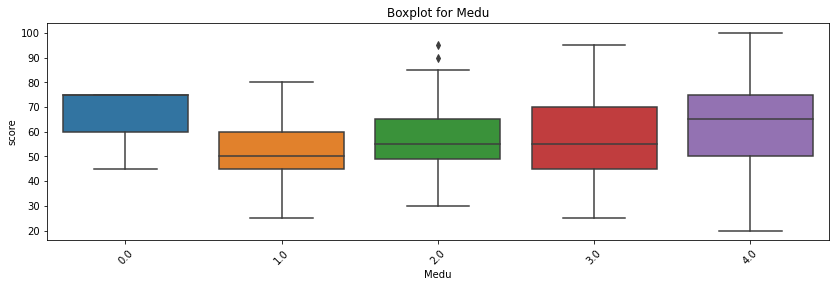

Значений, встретившихся в столбце более 5 раз: 4
Найдены статистически значимые различия для колонки Medu в количестве 1 комбинаций из 6


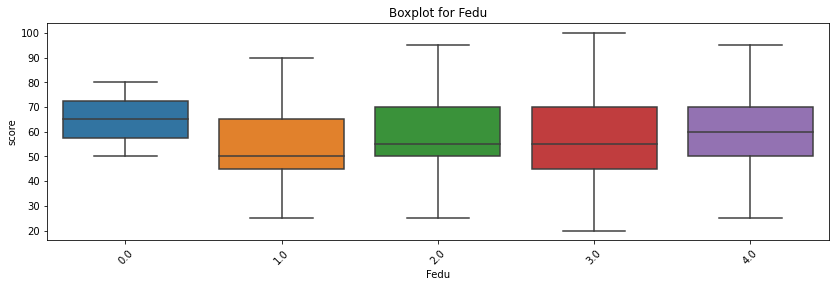

Значений, встретившихся в столбце более 5 раз: 4
Найдены статистически значимые различия для колонки Fedu в количестве 1 комбинаций из 6


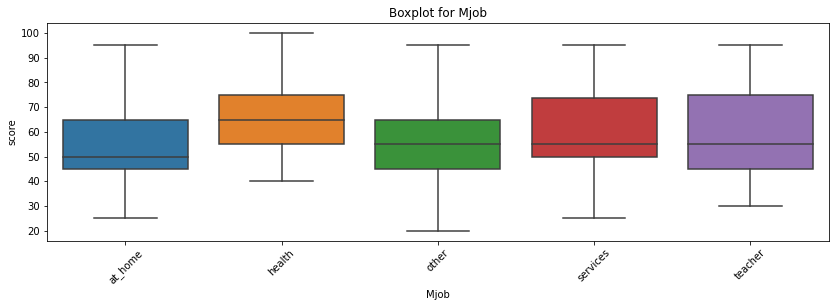

Значений, встретившихся в столбце более 5 раз: 5
Найдены статистически значимые различия для колонки Mjob в количестве 2 комбинаций из 10


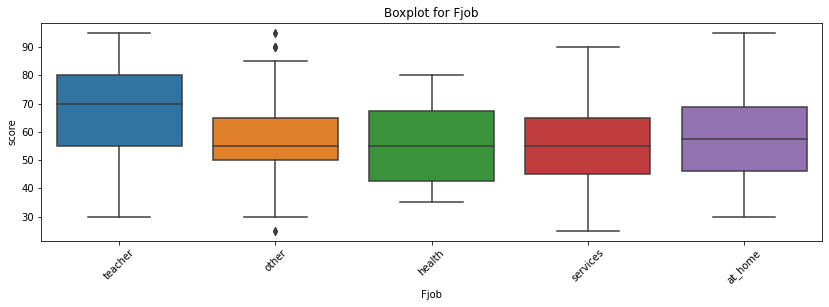

Значений, встретившихся в столбце более 5 раз: 5
Найдены статистически значимые различия для колонки Fjob в количестве 2 комбинаций из 10


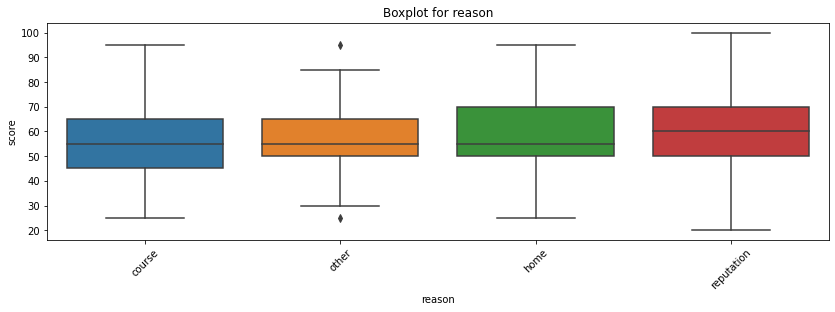

Значений, встретившихся в столбце более 5 раз: 4
НЕ Найдены статистически значимые различия для колонки reason


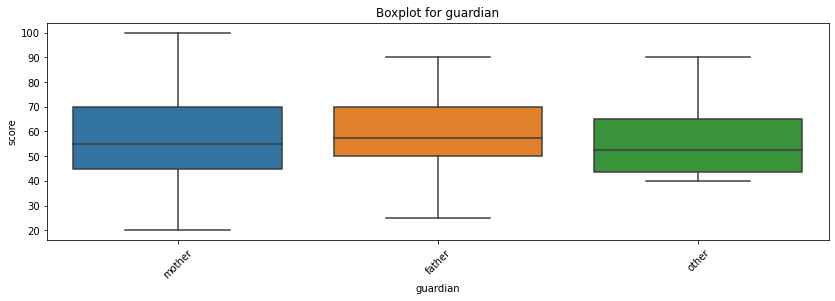

Значений, встретившихся в столбце более 5 раз: 3
НЕ Найдены статистически значимые различия для колонки guardian


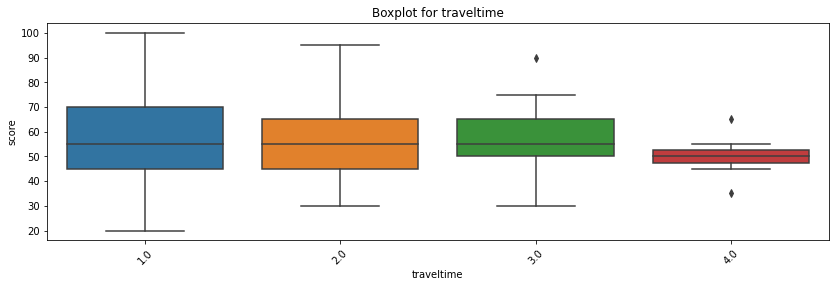

Значений, встретившихся в столбце более 5 раз: 4
НЕ Найдены статистически значимые различия для колонки traveltime


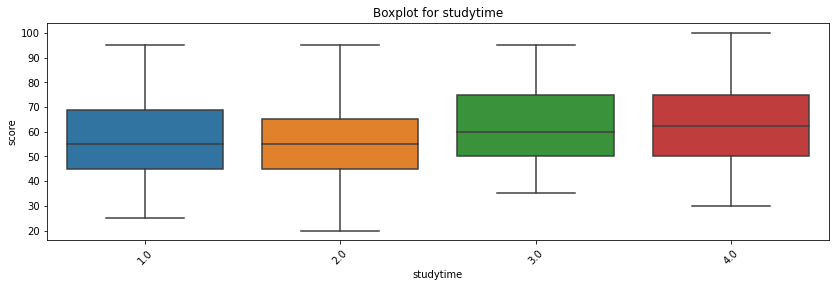

Значений, встретившихся в столбце более 5 раз: 4
Найдены статистически значимые различия для колонки studytime в количестве 1 комбинаций из 6


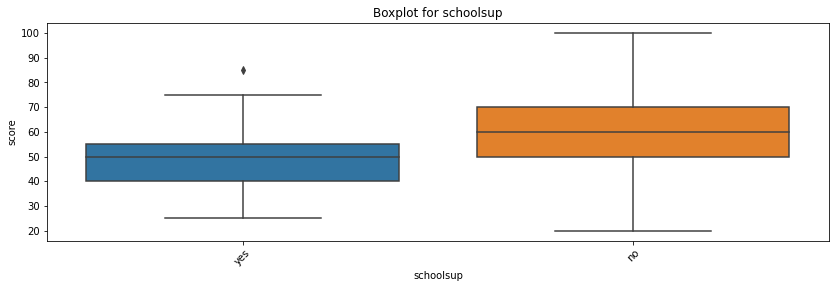

Значений, встретившихся в столбце более 5 раз: 2
Найдены статистически значимые различия для колонки schoolsup в количестве 1 комбинаций из 1


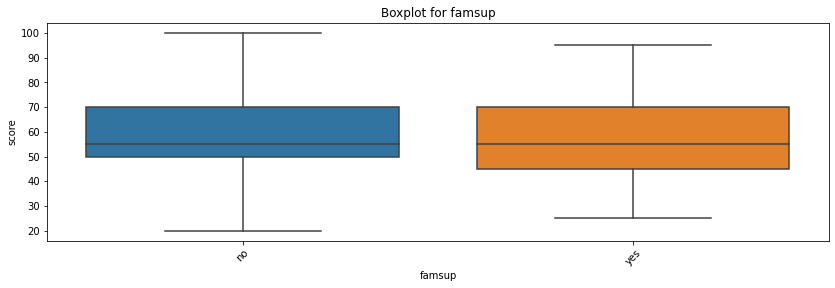

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки famsup


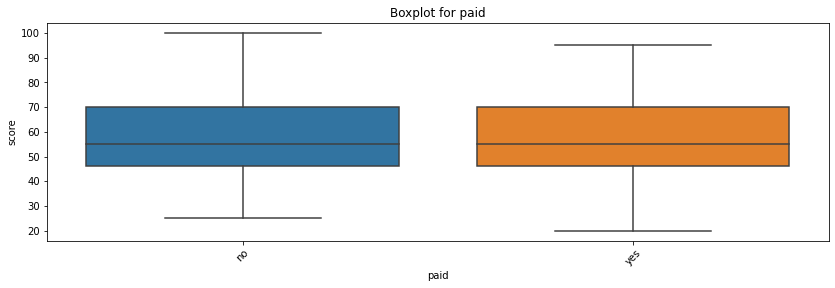

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки paid


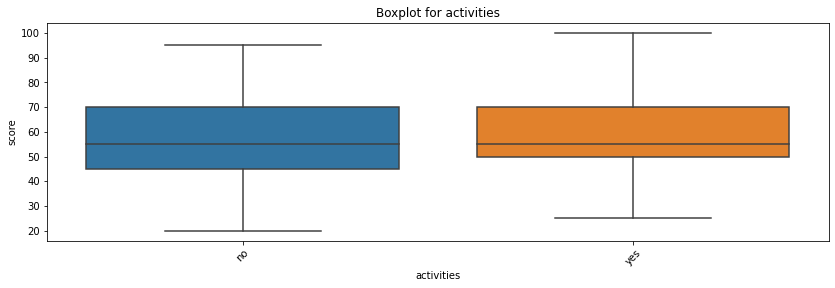

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки activities


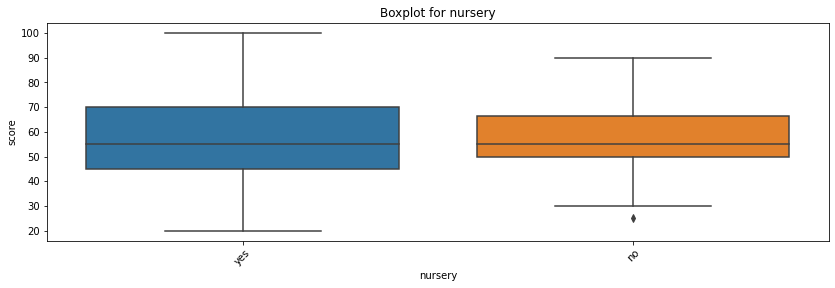

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки nursery


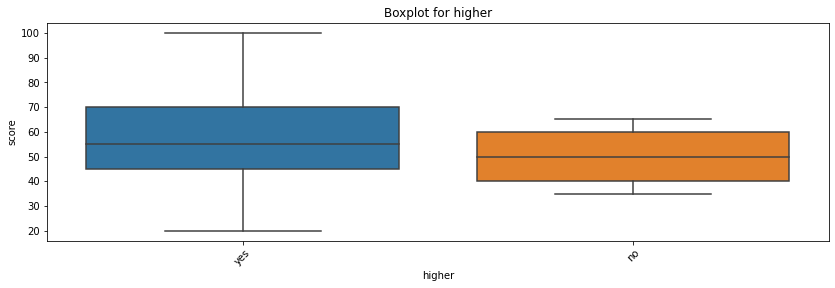

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки higher


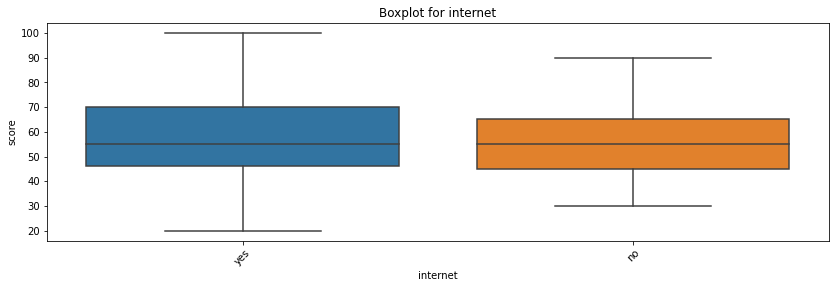

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки internet


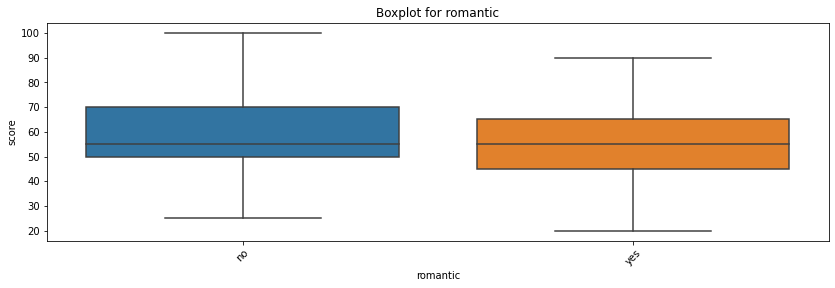

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки romantic


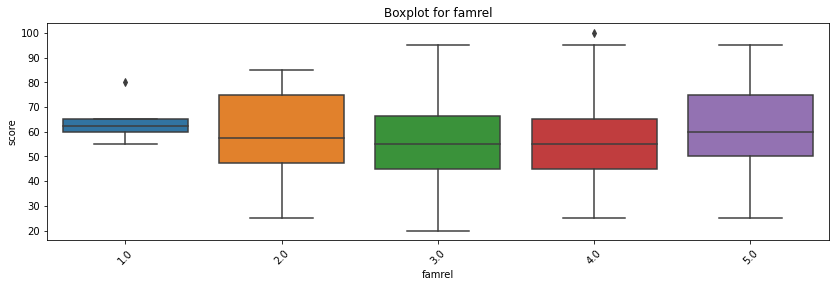

Значений, встретившихся в столбце более 5 раз: 5
НЕ Найдены статистически значимые различия для колонки famrel


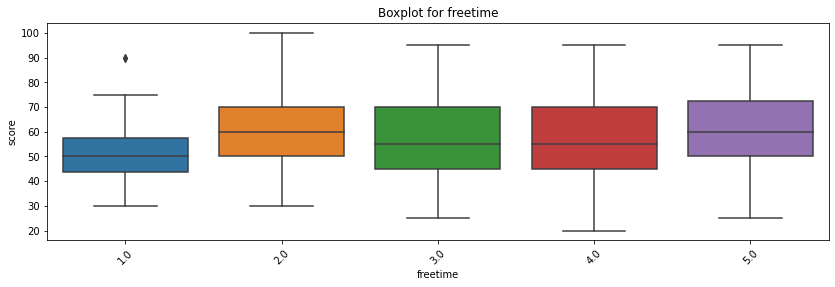

Значений, встретившихся в столбце более 5 раз: 5
НЕ Найдены статистически значимые различия для колонки freetime


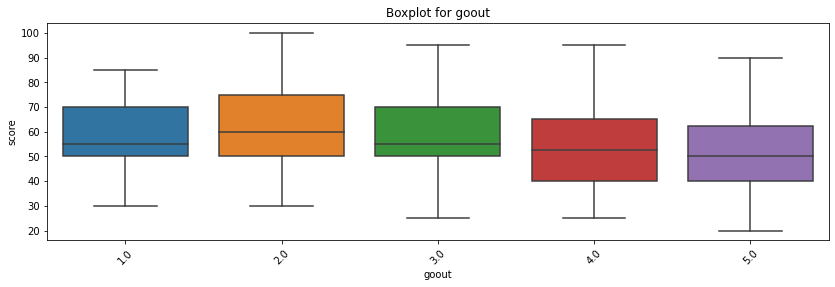

Значений, встретившихся в столбце более 5 раз: 5
Найдены статистически значимые различия для колонки goout в количестве 2 комбинаций из 10


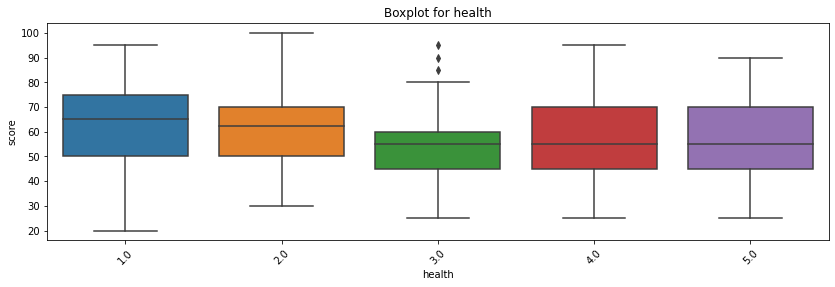

Значений, встретившихся в столбце более 5 раз: 5
НЕ Найдены статистически значимые различия для колонки health


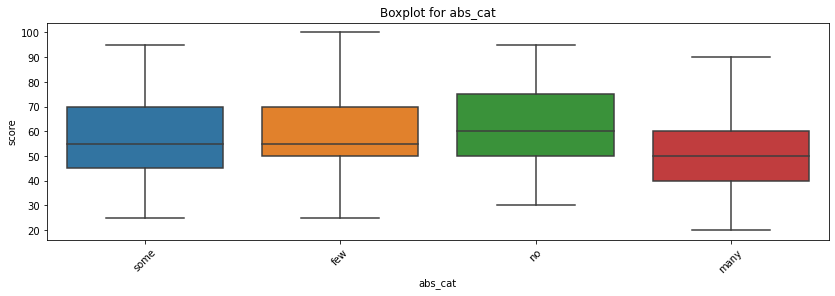

Значений, встретившихся в столбце более 5 раз: 4
Найдены статистически значимые различия для колонки abs_cat в количестве 2 комбинаций из 6


In [32]:
for col in cols:
    nominative_analysis(students.query('score != 0'), col, 'score')

Статистически значимые различия показали следующие столбцы:  
address, Medu, Fedu, Mjob, Fjob, studytime, schoolsup, goout, abs_cat  
Дополнительно рассмотрим, как номинативные переменные влияют на переменную score0, показывающую, получил ли студент 0 на экзамене.

In [33]:
cols = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
        'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
        'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
        'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
        'health', 'abs_cat'] # вспоминаем про age, т.к. не оценивали это влияние ранее
for col in cols:
    get_stat_dif(students, col, 'score0')

Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки school
Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки sex
Значений, встретившихся в столбце более 5 раз: 5
НЕ Найдены статистически значимые различия для колонки age
Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки address
Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки famsize
Значений, встретившихся в столбце более 5 раз: 2
НЕ Найдены статистически значимые различия для колонки Pstatus
Значений, встретившихся в столбце более 5 раз: 4
Найдены статистически значимые различия для колонки Medu в количестве 1 комбинаций из 6
Значений, встретившихся в столбце более 5 раз: 4
НЕ Найдены статистически значимые различия для колонки Fedu
Значений, встретившихся в столбце более 5 раз: 5
НЕ Найдены статистически значимые различия

Анализ показал, что на вероятность получить 0 на экзамене влияют следующие номинативные переменные:  
Medu, paid, higher, romantic, abs_cat  
На оценку в целом влияют следующие номинативные переменные:
address, Medu, Mjob, higher, romantic, goout, abs_cat  
На величину оценки за экзамен в отсутствии строк с оценкой 0:   
address, Medu, Fedu, Mjob, Fjob, studytime, schoolsup, goout, abs_cat  
Отобранные ранее количественные переменные:  
Medu, Fedu, studytime, failures, goout, absences  
  
Объединяя все отобранные переменные, для построения модели оставляем:  
address, Medu, Fedu, Mjob, Fjob, studytime, failures, schoolsup, paid, higher, romantic, goout, abs_cat, absences  
  
Остальные столбцы можно исключить из рассмотрения. Произведем их удаление из датасета и посмотрим, какие данные остались для построения модели.

In [34]:
students.drop(['school', 'sex', 'age','famsize', 'Pstatus', 'reason',
               'guardian', 'traveltime', 'famsup', 'activities',
               'nursery', 'internet', 'famrel', 'freetime',
               'health'], axis=1, inplace=True)

In [35]:
students.sample(10)

,address,Medu,Fedu,Mjob,Fjob,studytime,failures,schoolsup,paid,higher,romantic,goout,abs_cat,score0,absences,score
107,U,3.0,3.0,services,NaN,3.0,NaN,no,no,yes,no,3.0,few,1,2.0,90.0
116,U,4.0,4.0,other,teacher,2.0,0.0,no,no,yes,no,3.0,few,1,2.0,70.0
338,U,3.0,3.0,services,services,4.0,0.0,no,no,yes,no,3.0,some,1,7.0,85.0
61,U,1.0,1.0,services,services,1.0,0.0,yes,no,yes,yes,5.0,some,1,6.0,55.0
143,U,1.0,1.0,at_home,at_home,1.0,0.0,no,no,yes,no,4.0,few,1,2.0,65.0
34,U,3.0,2.0,other,other,1.0,0.0,no,yes,NaN,no,3.0,no,1,0.0,75.0
264,U,2.0,2.0,at_home,services,3.0,0.0,no,yes,yes,yes,3.0,no,0,0.0,0.0
24,R,2.0,4.0,services,health,3.0,0.0,yes,yes,yes,no,2.0,NaN,1,NaN,40.0
328,U,4.0,NaN,teacher,services,3.0,0.0,no,yes,yes,no,4.0,some,1,7.0,45.0
30,U,4.0,4.0,health,services,2.0,0.0,no,yes,yes,no,2.0,no,1,0.0,60.0


### Выводы
1) В исходных данных во всех колонках, кроме school, sex и age присутствуют пустые значения, их величина варьируется от 1 до 11%. Были обнаружены несколько пропусков в значениях score, строки были удалены из датасета. Заполнить пропуски на текущем этапе нет возможности.  
2) В столбцах Fedu и famrel были обнаружены выбросы обусловленные некачественным сбором данных. В столбце absences также были обнаружены выбросы связанные с недостаточным качеством сбора данных (более 100, 200 и даже 300 пропусков в учебном году), также были выбросы из-за слишком большого количества пропусков (более 40). Все они были исключены из датасета.  
3) В столбце score величина распределена приблизительно нормально, но имеется скачок в минимальной точке - 0. Это видимо обусловлено что ученики получают 0 баллов не только за незнание предмета, но также возможна неявка, удаление с экзамена и т.д. Поэтому при построении модели определение целевой переменной решено делать в два этапа: сначала определить, получит ли студент 0 баллов, а затем при низкой вероятности этого события уже спрогнозировать количество баллов на экзамене. Для оценки возможности получения студентом 0 баллов на экзамене в датасет была добавлена колонка score0 (равна 0 если студент получает 0 баллов или 1 если не 0 баллов).   
4) Для оценки пропусков студентов количественная переменная absences была преобразована в новую номинативную переменную abs_cat. Это обусловлено пониманием, что не всегда есть возможность посчитать точное количество пропусков. Но переменную absences на этом этапе решено оставить.  
5) Примечательно, что пол, возраст, здоровье, размер семьи, отношения внутри семьи и количество свободного времени учеников никак не влияют на оценку на экзамене.  
6) Для дальнейшего построения модели рекомендуется использовать следующие параметры:  
address, Medu, Fedu, Mjob, Fjob, studytime, failures, schoolsup, paid, higher, romantic, goout, abs_cat, absences